### Load libraries and data

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('./preprocessed_log_data.csv')

In [6]:
df['energy_mark'] = df['energy_mark'].apply(lambda x: 'A' if x[0]=='A' else ('none' if x[0]=='n' else 'B-G'))

In [7]:
df.columns

Index(['housing_type', 'size_sqm', 'rooms', 'floor', 'furnished',
       'roommate_friendly', 'pets_allowed', 'elevator', 'senior_friendly',
       'students_only', 'balcony_terrace', 'parking', 'dishwasher',
       'washing_machine', 'charging_station', 'dryer', 'energy_mark', 'area',
       'availability_in', 'days_on_website', 'student_affordable',
       'months_on_website', 'monthly_rent_log', 'monthly_aconto_log',
       'deposit_log', 'prepaid_rent_log', 'total_monthly_rent_log'],
      dtype='object')

In [8]:
# Dropping the columns that are used to create total_monthly_rent_log
df.drop(columns=['monthly_rent_log', 'monthly_aconto_log','deposit_log', 'prepaid_rent_log'], inplace=True)

In [9]:
# Splitting the data into features and target for regression
X_reg_no_dummies = df.drop(columns=['total_monthly_rent_log']).copy()
y_reg = df['total_monthly_rent_log'].copy()

# Splitting the data into features and target for classification
X_cls_no_dummies = df.drop(columns=['energy_mark']).copy()
y_cls = df['energy_mark'].copy()

In [10]:
# Make the categorical variables into dummies
X_reg = pd.get_dummies(X_reg_no_dummies).to_numpy()
X_cls = pd.get_dummies(X_cls_no_dummies).to_numpy()

y_reg = y_reg.to_numpy()
y_cls = y_cls.to_numpy()

### Model development

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
df

,housing_type,size_sqm,rooms,floor,furnished,roommate_friendly,pets_allowed,elevator,senior_friendly,students_only,...,washing_machine,charging_station,dryer,energy_mark,area,availability_in,days_on_website,student_affordable,months_on_website,total_monthly_rent_log
0,Lejlighed,86.0,3,3,Ja,Nej,Nej,Nej,Nej,Nej,...,Ja,Ikke angivet,Ikke angivet,B-G,Frederiksberg C,<1 month,10.0,False,<1 month,9.561068
1,Lejlighed,113.0,4,4,Nej,Nej,Ja,Ja,Nej,Nej,...,Ja,Nej,Ja,A,Bagsværd,1-3 months,10.0,False,<1 month,9.736547
2,Værelse,9.0,1,0,Ja,Ja,Nej,Nej,Nej,Nej,...,Ja,Ikke angivet,Ja,A,Kastrup,1-3 months,10.0,True,<1 month,8.699681
3,Værelse,14.0,1,0,Ja,Ja,Nej,Nej,Nej,Nej,...,Ja,Nej,Ja,B-G,København S,1-3 months,10.0,True,<1 month,8.294300
4,Værelse,7.0,1,4,Ja,Nej,Nej,Ja,Nej,Ja,...,Ikke angivet,Ikke angivet,Ikke angivet,none,København V,<1 month,10.0,True,<1 month,8.444838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,Lejlighed,30.0,1,0,Ja,Ja,Ja,Ja,Ja,Nej,...,Ja,Ja,Ja,none,Nærum,<1 month,880.0,False,6+ months,9.735128
1817,Lejlighed,115.0,4,1,Nej,Ja,Nej,Ja,Ikke angivet,Ikke angivet,...,Ikke angivet,Nej,Ikke angivet,none,Herlev,<1 month,944.0,False,6+ months,9.651559
1818,Værelse,15.0,1,3,Ja,Ja,Ja,Nej,Nej,Nej,...,Ja,Ikke angivet,Ja,none,København Ø,<1 month,1158.0,False,6+ months,8.987322
1819,Lejlighed,125.0,3,4,Ja,Ja,Nej,Nej,Nej,Nej,...,Ja,Nej,Ja,A,København V,3+ months,1168.0,False,6+ months,10.239996


In [35]:
# Placeholder data - load your actual data here
X = X_reg  # Feature matrix
y = y_reg  # Target variable

# Define hyperparameter grids
lambda_values = [100, 1000, 10000, 25000, 50000]  # Example values for regularization in Ridge
hidden_units_values = [1, 2, 4, 8, 16, 32, 64]  # Example values for ANN hidden units

# Outer cross-validation
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
outer_results = []

# Outer CV loop
for outer_fold, (train_outer_idx, test_outer_idx) in enumerate(tqdm(outer_cv.split(X), desc="Outer CV")):
    X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
    y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

    # Standardize features based on outer train set
    scaler = StandardScaler()
    X_train_outer = scaler.fit_transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)

    # Inner cross-validation for hyperparameter tuning
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Initialize placeholders for best models and errors
    best_ann_mse, best_linreg_mse = float('inf'), float('inf')
    best_h, best_lambda = None, None

    # ANN tuning
    # Initialize dictionary to store errors for each hidden unit value across outer folds
    hidden_units_errors = {h: [] for h in hidden_units_values}

# ANN tuning
    for h in tqdm(hidden_units_values, desc="ANN Tuning"):
        ann_mses = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_inner_idx], X_train_outer[val_inner_idx]
            y_train_inner, y_val_inner = y[train_inner_idx], y[val_inner_idx]

            # Define ANN model
            model = lambda: nn.Sequential(
                nn.Linear(X_train_inner.shape[1], 2*h),
                nn.ReLU(),
                nn.Linear(2*h, h),
                nn.ReLU(),
                nn.Linear(h, 1),
            )
            ann_model = model()
            criterion = nn.MSELoss()
            optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

            # Train the model
            ann_model.train()
            for epoch in range(1000):
                optimizer.zero_grad()
                outputs = ann_model(torch.tensor(X_train_inner, dtype=torch.float32))
                loss = criterion(outputs, torch.tensor(y_train_inner, dtype=torch.float32).view(-1, 1))
                loss.backward()
                optimizer.step()

            # Validate the model
            ann_model.eval()
            with torch.no_grad():
                y_pred_val = ann_model(torch.tensor(X_val_inner, dtype=torch.float32)).numpy()
            ann_mse = mean_squared_error(y_val_inner, y_pred_val)
            ann_mses.append(ann_mse)

        avg_ann_mse = np.mean(ann_mses)
        hidden_units_errors[h].append(avg_ann_mse)  # Store the avg MSE for each h

        if avg_ann_mse < best_ann_mse:
            best_ann_mse = avg_ann_mse
            best_h = h

    # Linear regression tuning
    for lam in tqdm(lambda_values, desc="Linear Regression Tuning"):
        linreg_mses = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_inner_idx], X_train_outer[val_inner_idx]
            y_train_inner, y_val_inner = y[train_inner_idx], y[val_inner_idx]

            # Define linear model with regularization
            linreg_model = Ridge(alpha=lam)
            linreg_model.fit(X_train_inner, y_train_inner)
            y_pred_val = linreg_model.predict(X_val_inner)
            linreg_mse = mean_squared_error(y_val_inner, y_pred_val)
            linreg_mses.append(linreg_mse)

        avg_linreg_mse = np.mean(linreg_mses)
        if avg_linreg_mse < best_linreg_mse:
            best_linreg_mse = avg_linreg_mse
            best_lambda = lam

    # Train best models from inner loop on the entire outer training set
    ann_model = model()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ann_model.parameters(), lr=0.01)
    ann_model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = ann_model(torch.tensor(X_train_outer, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(y_train_outer, dtype=torch.float32).view(-1, 1))
        loss.backward()
        optimizer.step()

    ann_model.eval()
    with torch.no_grad():
        y_pred_test_ann = ann_model(torch.tensor(X_test_outer, dtype=torch.float32)).numpy()
    test_mse_ann = mean_squared_error(np.exp(y_test_outer)+1, np.exp(y_pred_test_ann)+1)

    linreg_model = Ridge(alpha=best_lambda)
    linreg_model.fit(X_train_outer, y_train_outer)
    y_pred_test_linreg = linreg_model.predict(X_test_outer)
    test_mse_linreg = mean_squared_error(np.exp(y_test_outer)+1, np.exp(y_pred_test_linreg)+1)

    # Baseline model (predicting the mean)
    baseline_model = DummyRegressor(strategy="mean")
    baseline_model.fit(X_train_outer, y_train_outer)
    y_pred_test_baseline = baseline_model.predict(X_test_outer)
    test_mse_baseline = mean_squared_error(np.exp(y_test_outer)+1, np.exp(y_pred_test_baseline)+1)

    # Append results for this outer fold
    outer_results.append({
        'outer_fold': outer_fold + 1,
        'best_h': best_h,
        'test_mse_ann': test_mse_ann,
        'best_lambda': best_lambda,
        'test_mse_linreg': test_mse_linreg,
        'test_mse_baseline': test_mse_baseline
    })

# Create a DataFrame to display results in table format
results_df = pd.DataFrame(outer_results)
print(results_df)

Linear Regression Tuning: 100%|██████████| 5/5 [00:00<00:00, 29.90it/s]
Outer CV: 10it [21:40, 130.07s/it]

   outer_fold  best_h  test_mse_ann  best_lambda  test_mse_linreg  \
0           1      64  1.475421e+10        50000     1.983034e+10   
1           2      64  1.726074e+10        10000     1.675404e+10   
2           3      64  1.935600e+10        25000     2.418953e+10   
3           4      64  3.431866e+10        50000     4.136076e+10   
4           5      64  1.643095e+08        50000     4.403135e+07   
5           6      64  2.321019e+10        50000     2.422277e+10   
6           7      64  2.818361e+07        10000     1.724419e+07   
7           8      64  3.601063e+08        50000     6.434736e+07   
8           9      64  4.301634e+09        10000     1.399827e+10   
9          10      64  1.261012e+10        25000     1.547718e+10   

   test_mse_baseline  
0       1.986468e+10  
1       1.680635e+10  
2       2.426877e+10  
3       4.139120e+10  
4       5.063747e+07  
5       2.426621e+10  
6       3.131637e+07  
7       7.241897e+07  
8       1.403018e+10  
9       1.

In [60]:
results_df

,Outer Fold,Best Hidden Units,Test MSE ANN,Best Lambda,Test MSE LinReg,Test MSE Baseline
0,1,64,147.54,50000,198.30,198.65
1,2,64,172.61,10000,167.54,168.06
2,3,64,193.56,25000,241.90,242.69
3,4,64,343.19,50000,413.61,413.91
4,5,64,1.64,50000,0.44,0.51
5,6,64,232.10,50000,242.23,242.66
6,7,64,0.28,10000,0.17,0.31
7,8,64,3.60,50000,0.64,0.72
8,9,64,43.02,10000,139.98,140.30
9,10,64,126.10,25000,154.77,155.31


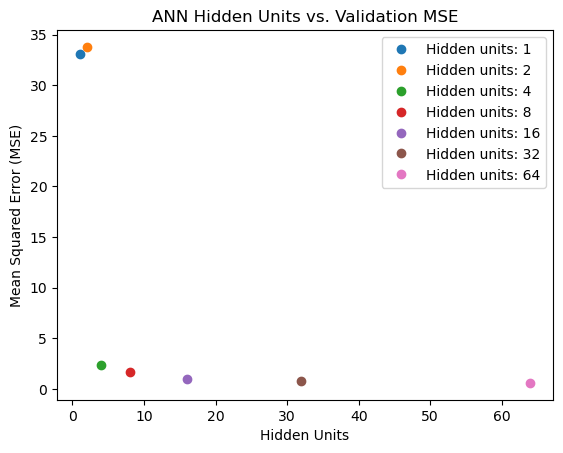

In [36]:
# After the outer loop, you can plot the MSEs for each hidden unit value
for h, errors in hidden_units_errors.items():
    plt.plot([h] * len(errors), errors, 'o', label=f'Hidden units: {h}')
plt.xlabel("Hidden Units")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("ANN Hidden Units vs. Validation MSE")
plt.legend()
plt.show()

### New attempt also with a GLM

In [76]:
# Define polynomial degree and lambda values for GLM
poly_degrees = [1, 2, 3]  # 1 for linear interactions, 2 for quadratic interactions
glm_lambda_values = [0.1, 1, 10, 100, 1000, 10000]
outer_results = []
# Outer CV loop
for outer_fold, (train_outer_idx, test_outer_idx) in enumerate(tqdm(outer_cv.split(X), desc="Outer CV")):
    X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
    y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

    # Standardize features based on outer train set
    scaler = StandardScaler()
    X_train_outer = scaler.fit_transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)

    # Inner cross-validation for hyperparameter tuning
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Initialize placeholders for best models and errors
    best_ann_mse, best_linreg_mse, best_glm_mse = float('inf'), float('inf'), float('inf')
    best_h, best_lambda, best_glm_params = None, None, None

    # ANN tuning
    for h in tqdm(hidden_units_values, desc="ANN Tuning"):
        ann_mses = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_inner_idx], X_train_outer[val_inner_idx]
            y_train_inner, y_val_inner = y[train_inner_idx], y[val_inner_idx]

            # Define ANN model
            model = lambda: nn.Sequential(
                nn.Linear(X_train_outer.shape[1], 2 * h),
                nn.ReLU(),
                nn.Linear(2 * h, h),
                nn.ReLU(),
                nn.Linear(h, 1),
            )
            ann_model = model()
            criterion = nn.MSELoss()
            optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

            # Train the model
            ann_model.train()
            for epoch in range(1000):
                optimizer.zero_grad()
                outputs = ann_model(torch.tensor(X_train_inner, dtype=torch.float32))
                loss = criterion(outputs, torch.tensor(y_train_inner, dtype=torch.float32).view(-1, 1))
                loss.backward()
                optimizer.step()

            # Validate the model
            ann_model.eval()
            with torch.no_grad():
                y_pred_val = ann_model(torch.tensor(X_val_inner, dtype=torch.float32)).numpy()
            ann_mse = mean_squared_error(y_val_inner, y_pred_val)
            ann_mses.append(ann_mse)

        avg_ann_mse = np.mean(ann_mses)
        if avg_ann_mse < best_ann_mse:
            best_ann_mse = avg_ann_mse
            best_h = h

    # Linear regression tuning
    for lam in tqdm(lambda_values, desc="Linear Regression Tuning"):
        linreg_mses = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_inner_idx], X_train_outer[val_inner_idx]
            y_train_inner, y_val_inner = y[train_inner_idx], y[val_inner_idx]

            # Define linear model with regularization
            linreg_model = Ridge(alpha=lam)
            linreg_model.fit(X_train_inner, y_train_inner)
            y_pred_val = linreg_model.predict(X_val_inner)
            linreg_mse = mean_squared_error(y_val_inner, y_pred_val)
            linreg_mses.append(linreg_mse)

        avg_linreg_mse = np.mean(linreg_mses)
        if avg_linreg_mse < best_linreg_mse:
            best_linreg_mse = avg_linreg_mse
            best_lambda = lam


    # GLM tuning with cross-join effects
    for degree in tqdm(poly_degrees, desc="GLM Tuning"):
        for lam in glm_lambda_values:
            glm_mses = []
            for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
                X_train_inner, X_val_inner = X_train_outer[train_inner_idx], X_train_outer[val_inner_idx]
                y_train_inner, y_val_inner = y[train_inner_idx], y[val_inner_idx]

                # Define GLM model with cross-join interactions
                glm_model = make_pipeline(
                    PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False),
                    Ridge(alpha=lam)
                )
                glm_model.fit(X_train_inner, y_train_inner)
                y_pred_val = glm_model.predict(X_val_inner)
                glm_mse = mean_squared_error(y_val_inner, y_pred_val)
                glm_mses.append(glm_mse)

            avg_glm_mse = np.mean(glm_mses)
            if avg_glm_mse < best_glm_mse:
                best_glm_mse = avg_glm_mse
                best_glm_params = {'degree': degree, 'lambda': lam}

    # Train best models from inner loop on the entire outer training set
    best_ann_model = lambda: nn.Sequential(
                nn.Linear(X_train_outer.shape[1], 2 * best_h),
                nn.ReLU(),
                nn.Linear(2 * best_h, best_h),
                nn.ReLU(),
                nn.Linear(best_h, 1),
            )
    ann_model = best_ann_model()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ann_model.parameters(), lr=0.01)
    ann_model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = ann_model(torch.tensor(X_train_outer, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(y_train_outer, dtype=torch.float32).view(-1, 1))
        loss.backward()
        optimizer.step()

    ann_model.eval()
    with torch.no_grad():
        y_pred_test_ann = ann_model(torch.tensor(X_test_outer, dtype=torch.float32)).numpy()
    test_mse_ann = mean_squared_error(np.exp(y_test_outer)+1, np.exp(y_pred_test_ann)+1)

    #Linear model
    linreg_model = Ridge(alpha=best_lambda)
    linreg_model.fit(X_train_outer, y_train_outer)
    y_pred_test_linreg = linreg_model.predict(X_test_outer)
    test_mse_linreg = mean_squared_error(np.exp(y_test_outer)+1, np.exp(y_pred_test_linreg)+1)

    # Baseline model (predicting the mean)
    baseline_model = DummyRegressor(strategy="mean")
    baseline_model.fit(X_train_outer, y_train_outer)
    y_pred_test_baseline = baseline_model.predict(X_test_outer)
    test_mse_baseline = mean_squared_error(np.exp(y_test_outer)+1, np.exp(y_pred_test_baseline)+1)

    # Train best GLM model on the outer training set
    glm_model = make_pipeline(
        PolynomialFeatures(degree=best_glm_params['degree'], interaction_only=True, include_bias=False),
        Ridge(alpha=best_glm_params['lambda'])
    )
    glm_model.fit(X_train_outer, y_train_outer)
    y_pred_test_glm = glm_model.predict(X_test_outer)
    test_mse_glm = mean_squared_error(np.exp(y_test_outer)+1, np.exp(y_pred_test_glm)+1)

    # Append results for this outer fold
    outer_results.append({
        'outer_fold': outer_fold + 1,
        'best_h': best_h,
        'test_mse_ann': test_mse_ann,
        'best_lambda': best_lambda,
        'test_mse_linreg': test_mse_linreg,
        'test_mse_baseline': test_mse_baseline,
        'best_glm_params': best_glm_params,
        'test_mse_glm': test_mse_glm
    })
    print(outer_results)
# Create a DataFrame to display results in table format
results1_df = pd.DataFrame(outer_results)

GLM Tuning: 100%|██████████| 3/3 [03:17<00:00, 65.92s/it]
Outer CV: 1it [04:55, 295.29s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

GLM Tuning: 100%|██████████| 3/3 [03:32<00:00, 70.84s/it]
Outer CV: 2it [09:59, 300.28s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

GLM Tuning: 100%|██████████| 3/3 [03:20<00:00, 66.89s/it]
Outer CV: 3it [14:52, 297.30s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

GLM Tuning: 100%|██████████| 3/3 [03:12<00:00, 64.30s/it]
Outer CV: 4it [19:34, 291.19s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

GLM Tuning: 100%|██████████| 3/3 [03:16<00:00, 65.64s/it]
Outer CV: 5it [24:19, 289.05s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

GLM Tuning: 100%|██████████| 3/3 [15:21<00:00, 307.26s/it]
Outer CV: 6it [41:09, 533.99s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

GLM Tuning: 100%|██████████| 3/3 [03:19<00:00, 66.35s/it]
Outer CV: 7it [45:59, 454.35s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

GLM Tuning: 100%|██████████| 3/3 [03:47<00:00, 75.74s/it] 
Outer CV: 8it [51:13, 409.55s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

GLM Tuning: 100%|██████████| 3/3 [03:26<00:00, 68.88s/it]
Outer CV: 9it [56:08, 373.78s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

GLM Tuning: 100%|██████████| 3/3 [03:29<00:00, 69.68s/it]
Outer CV: 10it [1:01:10, 367.04s/it]

[{'outer_fold': 1, 'best_h': 32, 'test_mse_ann': 738775384.165011, 'best_lambda': 10000, 'test_mse_linreg': 19643148183.13463, 'test_mse_baseline': 19864679985.78159}, {'outer_fold': 2, 'best_h': 32, 'test_mse_ann': 14262217148.607422, 'best_lambda': 10000, 'test_mse_linreg': 16709188939.313482, 'test_mse_baseline': 16806352404.63012}, {'outer_fold': 3, 'best_h': 32, 'test_mse_ann': 73573934.93377702, 'best_lambda': 10000, 'test_mse_linreg': 23991725642.129875, 'test_mse_baseline': 24268767874.281}, {'outer_fold': 4, 'best_h': 32, 'test_mse_ann': 22195685982.575184, 'best_lambda': 10000, 'test_mse_linreg': 41112373598.84125, 'test_mse_baseline': 41391200795.43109}, {'outer_fold': 5, 'best_h': 32, 'test_mse_ann': 32874327.04789609, 'best_lambda': 10000, 'test_mse_linreg': 30360551.52572315, 'test_mse_baseline': 50637469.84446768}, {'outer_fold': 6, 'best_h': 32, 'test_mse_ann': 53125658.79258171, 'best_lambda': 10000, 'test_mse_linreg': 23990686935.699535, 'test_mse_baseline': 242662144

In [77]:
len(outer_results)

30

### New attempt with MLP Regressor instead of the ANN

In [21]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np
import pandas as pd

# Placeholder data - load your actual data here
X = X_reg  # Feature matrix
y = y_reg  # Target variable

# Define hyperparameter grids
lambda_values = [100, 355, 1000, 10000, 50000]  # Example values for regularization in Ridge
hidden_units_values = [1, 2, 4, 8, 16, 32, 64]  # Example values for ANN hidden units

# Outer cross-validation
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
outer_results = []

# Outer CV loop
for outer_fold, (train_outer_idx, test_outer_idx) in enumerate(tqdm(outer_cv.split(X), desc="Outer CV")):
    X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
    y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

    # Standardize features based on outer train set
    scaler = StandardScaler()
    X_train_outer = scaler.fit_transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)

    # Inner cross-validation for hyperparameter tuning
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Initialize placeholders for best models and errors
    best_ann_mse, best_linreg_mse = float('inf'), float('inf')
    best_h, best_lambda = None, None

    # ANN tuning with MLPRegressor
    hidden_units_errors = {h: [] for h in hidden_units_values}

    for h in tqdm(hidden_units_values, desc="ANN Tuning"):
        ann_mses = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_inner_idx], X_train_outer[val_inner_idx]
            y_train_inner, y_val_inner = y[train_inner_idx], y[val_inner_idx]

            # Define MLPRegressor model with hidden units
            ann_model = MLPRegressor(hidden_layer_sizes=(h), activation='relu', solver='adam', max_iter=1000, random_state=42)
            ann_model.fit(X_train_inner, y_train_inner)
            y_pred_val = ann_model.predict(X_val_inner)
            ann_mse = mean_squared_error(y_val_inner, y_pred_val)
            ann_mses.append(ann_mse)

        avg_ann_mse = np.mean(ann_mses)
        hidden_units_errors[h].append(avg_ann_mse)

        if avg_ann_mse < best_ann_mse:
            best_ann_mse = avg_ann_mse
            best_h = h

    # Linear regression tuning
    for lam in tqdm(lambda_values, desc="Linear Regression Tuning"):
        linreg_mses = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_inner_idx], X_train_outer[val_inner_idx]
            y_train_inner, y_val_inner = y[train_inner_idx], y[val_inner_idx]

            # Define linear model with regularization
            linreg_model = Ridge(alpha=lam)
            linreg_model.fit(X_train_inner, y_train_inner)
            y_pred_val = linreg_model.predict(X_val_inner)
            linreg_mse = mean_squared_error(y_val_inner, y_pred_val)
            linreg_mses.append(linreg_mse)

        avg_linreg_mse = np.mean(linreg_mses)
        if avg_linreg_mse < best_linreg_mse:
            best_linreg_mse = avg_linreg_mse
            best_lambda = lam

    # Train best MLPRegressor model from inner loop on the entire outer training set
    ann_model = MLPRegressor(hidden_layer_sizes=(best_h), activation='relu', solver='adam', max_iter=1000, random_state=42)
    ann_model.fit(X_train_outer, y_train_outer)
    y_pred_test_ann = ann_model.predict(X_test_outer)
    test_mse_ann = mean_squared_error(np.exp(y_test_outer) + 1, np.exp(y_pred_test_ann) + 1)

    # Train best Ridge model from inner loop on the entire outer training set
    linreg_model = Ridge(alpha=best_lambda)
    linreg_model.fit(X_train_outer, y_train_outer)
    y_pred_test_linreg = linreg_model.predict(X_test_outer)
    test_mse_linreg = mean_squared_error(np.exp(y_test_outer) + 1, np.exp(y_pred_test_linreg) + 1)

    # Baseline model (predicting the mean)
    baseline_model = DummyRegressor(strategy="mean")
    baseline_model.fit(X_train_outer, y_train_outer)
    y_pred_test_baseline = baseline_model.predict(X_test_outer)
    test_mse_baseline = mean_squared_error(np.exp(y_test_outer) + 1, np.exp(y_pred_test_baseline) + 1)

    # Append results for this outer fold
    outer_results.append({
        'outer_fold': outer_fold + 1,
        'best_h': best_h,
        'test_mse_ann': test_mse_ann,
        'best_lambda': best_lambda,
        'test_mse_linreg': test_mse_linreg,
        'test_mse_baseline': test_mse_baseline
    })

# Create a DataFrame to display results in table format
results_df = pd.DataFrame(outer_results)
print(results_df)

Linear Regression Tuning: 100%|██████████| 5/5 [00:00<00:00, 46.46it/s]
Outer CV: 10it [20:09, 120.95s/it]

   outer_fold  best_h  test_mse_ann  best_lambda  test_mse_linreg  \
0           1      64  1.640120e+10        50000     1.983034e+10   
1           2      64  1.657906e+10        10000     1.675404e+10   
2           3      64  2.371009e+10        50000     2.422439e+10   
3           4      64  3.607874e+10        50000     4.136076e+10   
4           5      64  1.477008e+08        50000     4.403135e+07   
5           6       2  2.470368e+10        50000     2.422277e+10   
6           7      64  1.121932e+09        10000     1.724419e+07   
7           8      64  4.171267e+08        50000     6.434736e+07   
8           9      64  1.148567e+10        10000     1.399827e+10   
9          10      64  1.267704e+10        10000     1.542314e+10   

   test_mse_baseline  
0       1.986468e+10  
1       1.680635e+10  
2       2.426877e+10  
3       4.139120e+10  
4       5.063747e+07  
5       2.426621e+10  
6       3.131637e+07  
7       7.241897e+07  
8       1.403018e+10  
9       1.

(array([  5.,  15.,  24.,  38.,  33.,  63.,  56.,  73., 112., 152., 198.,
        327., 274., 148.,  99.,  52.,  55.,  25.,  13.,  23.,  12.,   6.,
          2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   3.,   7.,   3.]),
 array([ 8.0481491 ,  8.17480605,  8.301463  ,  8.42811995,  8.55477689,
         8.68143384,  8.80809079,  8.93474774,  9.06140469,  9.18806164,
         9.31471858,  9.44137553,  9.56803248,  9.69468943,  9.82134638,
         9.94800332, 10.07466027, 10.20131722, 10.32797417, 10.45463112,
        10.58128807, 10.70794501, 10.83460196, 10.96125891, 11.08791586,
        11.21457281, 11.34122975, 11.4678867 , 11.59454365, 11.7212006 ,
        11.84785755, 11.9745145 , 12.10117144, 12.22782839, 12.35448534,
        12.48114229, 12.60779924, 12.73445618, 12.86111313, 12.98777008,
        13.11442703, 13.24108398, 13.36774093, 13.49439787, 13.62105482,
 

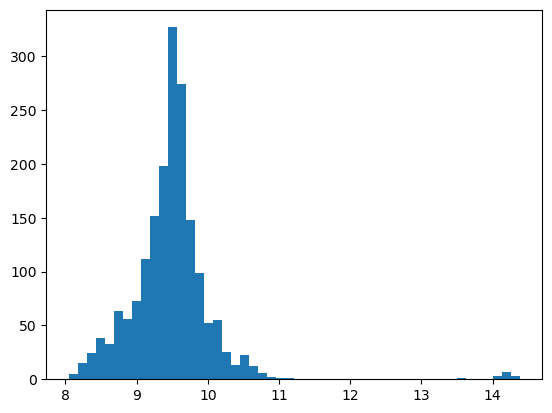

In [26]:
plt.hist(y_reg, bins=50)

### Format results 

In [37]:
results_df.columns = ['Outer Fold', 'Best Hidden Units', 'Test MSE ANN', 'Best Lambda', 'Test MSE LinReg', 'Test MSE Baseline']

In [38]:
results_df['Test MSE ANN'] = results_df['Test MSE ANN'].apply(lambda x: round(x/10**8, 2))

results_df['Test MSE LinReg'] = results_df['Test MSE LinReg'].apply(lambda x: round(x/10**8, 2))

results_df['Test MSE Baseline'] = results_df['Test MSE Baseline'].apply(lambda x: round(x/10**8, 2))

In [59]:
results_df.to_latex()

'\\begin{tabular}{lllllll}\n\\toprule\n & Outer Fold & Best Hidden Units & Test MSE ANN & Best Lambda & Test MSE LinReg & Test MSE Baseline \\\\\n\\midrule\n0 & 1 & 32 & 2.3e+08 & 10 & 181.56e+08 & 198.65e+08 \\\\\n1 & 2 & 32 & 142.94e+08 & 10 & 160.59e+08 & 168.06e+08 \\\\\n2 & 3 & 32 & 1.37e+08 & 10 & 220.74e+08 & 242.69e+08 \\\\\n3 & 4 & 32 & 195.35e+08 & 10 & 395.08e+08 & 413.91e+08 \\\\\n4 & 5 & 32 & 0.33e+08 & 10 & 0.1e+08 & 0.51e+08 \\\\\n5 & 6 & 32 & 2.08e+08 & 10 & 220.11e+08 & 242.66e+08 \\\\\n6 & 7 & 32 & 0.72e+08 & 10 & 0.07e+08 & 0.31e+08 \\\\\n7 & 8 & 32 & 0.37e+08 & 10 & 0.18e+08 & 0.72e+08 \\\\\n8 & 9 & 32 & 4.74e+08 & 10 & 131.32e+08 & 140.3e+08 \\\\\n9 & 10 & 32 & 33.32e+08 & 10 & 142.3e+08 & 155.31e+08 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
results1_df.iloc[20:,:]

In [39]:
results_df

,Outer Fold,Best Hidden Units,Test MSE ANN,Best Lambda,Test MSE LinReg,Test MSE Baseline
0,1,64,147.54,50000,198.30,198.65
1,2,64,172.61,10000,167.54,168.06
2,3,64,193.56,25000,241.90,242.69
3,4,64,343.19,50000,413.61,413.91
4,5,64,1.64,50000,0.44,0.51
5,6,64,232.10,50000,242.23,242.66
6,7,64,0.28,10000,0.17,0.31
7,8,64,3.60,50000,0.64,0.72
8,9,64,43.02,10000,139.98,140.30
9,10,64,126.10,25000,154.77,155.31


In [47]:
pd.concat([pd.Series(np.exp(y_pred_test_ann.reshape(1,-1)[0])-1), pd.Series(np.exp(y_pred_test_linreg)-1), pd.Series(np.exp(y_pred_test_baseline)-1), pd.Series(np.exp(y_test_outer)-1)], axis=1)

,0,1,2,3
0,6604.652344,13102.536741,13098.37057,10100.0
1,13244.120117,11582.568665,13098.37057,17900.0
2,11881.954102,14159.868024,13098.37057,12650.0
3,10661.187500,13873.411670,13098.37057,10850.0
4,39454.609375,14789.296179,13098.37057,15890.0
...,...,...,...,...
177,12645.033203,13799.379755,13098.37057,13300.0
178,88154.875000,15953.917394,13098.37057,47500.0
179,20311.041016,13111.429824,13098.37057,21200.0
180,10428.123047,11887.991663,13098.37057,13550.0


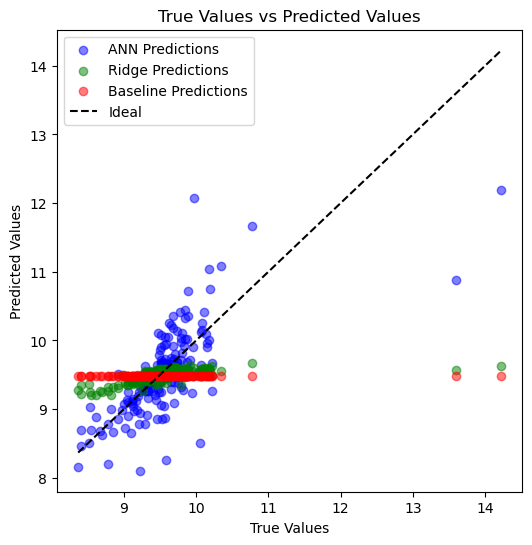

In [61]:
plt.figure(figsize=(6, 6))

# Plot y_test_outer vs y_pred_test_ann
plt.scatter(y_test_outer, y_pred_test_ann, color='blue', alpha=0.5, label='ANN Predictions')

# Plot y_test_outer vs y_pred_test_linreg
plt.scatter(y_test_outer, y_pred_test_linreg, color='green', alpha=0.5, label='Ridge Predictions')

# Plot y_test_outer vs y_pred_test_baseline
plt.scatter(y_test_outer, y_pred_test_baseline, color='red', alpha=0.5, label='Baseline Predictions')

# Plot the ideal line
plt.plot([min(y_test_outer), max(y_test_outer)], [min(y_test_outer), max(y_test_outer)], color='black', linestyle='--', label='Ideal')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs Predicted Values')
plt.legend()
plt.show()

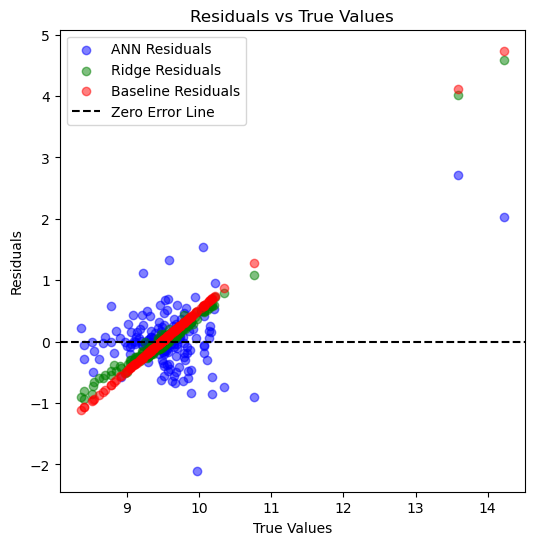

In [62]:
# Calculate residuals
residuals_ann = y_test_outer - y_pred_test_ann.flatten()
residuals_linreg = y_test_outer - y_pred_test_linreg
residuals_baseline = y_test_outer - y_pred_test_baseline

# Plot residuals
plt.figure(figsize=(6, 6))

# Plot residuals for ANN
plt.scatter(y_test_outer, residuals_ann, color='blue', alpha=0.5, label='ANN Residuals')

# Plot residuals for Ridge Regression
plt.scatter(y_test_outer, residuals_linreg, color='green', alpha=0.5, label='Ridge Residuals')

# Plot residuals for Baseline
plt.scatter(y_test_outer, residuals_baseline, color='red', alpha=0.5, label='Baseline Residuals')

plt.axhline(y=0, color='black', linestyle='--', label='Zero Error Line')

plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals vs True Values')
plt.legend()
plt.show()

### Check best model

In [51]:
# Define ANN model
model = lambda h: nn.Sequential(
    nn.Linear(X_train_inner.shape[1], 2*h),
    nn.ReLU(),
    nn.Linear(2*h, h),
    nn.ReLU(),
    nn.Linear(h, 1),
)

In [52]:
X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

# Standardize features based on outer train set
scaler = StandardScaler()
X_train_outer = scaler.fit_transform(X_train_outer)
X_test_outer = scaler.transform(X_test_outer)


# Train best models from inner loop on the entire outer training set
ann_model = model(64)
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.01)
ann_model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = ann_model(torch.tensor(X_train_outer, dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(y_train_outer, dtype=torch.float32).view(-1, 1))
    loss.backward()
    optimizer.step()

ann_model.eval()
with torch.no_grad():
    y_pred_test_ann = ann_model(torch.tensor(X_test_outer, dtype=torch.float32)).numpy()
test_mse_ann = mean_squared_error(np.exp(y_test_outer)+1, np.exp(y_pred_test_ann)+1)



In [53]:
pred_vs_true = pd.concat([pd.DataFrame(np.exp(y_test_outer)+1), pd.DataFrame(np.exp(y_pred_test_ann)+1)], axis=1)
pred_vs_true.columns = ['true', 'pred']

In [54]:
pred_vs_true['diff'] = abs(pred_vs_true['true'] - pred_vs_true['pred'])

In [55]:
pred_vs_true.describe()

,true,pred,diff
count,1.820000e+02,182.000000,1.820000e+02
mean,2.673741e+04,17519.994141,1.620248e+04
std,1.242160e+05,21489.777344,1.111521e+05
min,4.302000e+03,3304.180664,8.431152e+00
25%,1.102700e+04,10222.199463,6.450813e+02
50%,1.350200e+04,12894.438965,1.746827e+03
75%,1.675075e+04,16806.477539,5.091778e+03
max,1.497352e+06,196778.296875,1.300574e+06


### Test for best model with Setup II

In [58]:
# Define ANN model
def create_ann_model(input_size, h):
    return nn.Sequential(
        nn.Linear(input_size, 2 * h),
        nn.ReLU(),
        nn.Linear(2 * h, h),
        nn.ReLU(),
        nn.Linear(h, 1),
    )

# Function to evaluate models
def evaluate_models(X, y, n_splits=10, h=16, lambda_reg=50000):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    ann_errors = []
    ridge_errors = []
    baseline_errors = []
    
    # Baseline prediction (mean)
    baseline_prediction = np.mean(y)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardize features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train Ridge Regression
        ridge_model = Ridge(alpha=lambda_reg)
        ridge_model.fit(X_train, y_train)
        ridge_pred = ridge_model.predict(X_test)
        ridge_errors.append(mean_squared_error(y_test, ridge_pred))

        # Train ANN
        ann_model = create_ann_model(X_train.shape[1], h)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(ann_model.parameters(), lr=0.01)
        ann_model.train()

        # Training Loop
        for epoch in range(1000):
            optimizer.zero_grad()
            outputs = ann_model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
            loss.backward()
            optimizer.step()

        # Evaluation
        ann_model.eval()
        with torch.no_grad():
            y_pred_ann = ann_model(torch.tensor(X_test, dtype=torch.float32)).numpy()
        ann_errors.append(mean_squared_error(y_test, y_pred_ann))

        # Calculate Baseline Error
        baseline_errors.append(mean_squared_error(y_test, [baseline_prediction]*len(y_test)))

    return np.array(ann_errors), np.array(ridge_errors), np.array(baseline_errors)


# Evaluate models
h_value = 64  # Hidden units for ANN
lambda_value = 50000  # Regularization parameter for Ridge
ann_errors, ridge_errors, baseline_errors = evaluate_models(X, y, h=h_value, lambda_reg=lambda_value)

# Function to perform correlated t-test
def correlated_t_test(model_a_errors, model_b_errors):
    differences = model_a_errors - model_b_errors
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)
    J = len(differences)
    
    # t-statistic
    t_stat = mean_diff / (std_diff / np.sqrt(J))
    df = J - 1
    p_value = 2 * stats.t.cdf(-np.abs(t_stat), df)
    
    # Confidence interval
    alpha = 0.05
    ci_low = mean_diff - stats.t.ppf(1 - alpha / 2, df) * (std_diff / np.sqrt(J))
    ci_high = mean_diff + stats.t.ppf(1 - alpha / 2, df) * (std_diff / np.sqrt(J))
    
    return mean_diff, std_diff, p_value, (ci_low, ci_high)

# Pairwise comparisons
results = {}

# ANN vs Ridge Regression
results['ANN vs Ridge Regression'] = correlated_t_test(ann_errors, ridge_errors)

# ANN vs Baseline
results['ANN vs Baseline'] = correlated_t_test(ann_errors, baseline_errors)

# Ridge Regression vs Baseline
results['Ridge Regression vs Baseline'] = correlated_t_test(ridge_errors, baseline_errors)

# Print results
for comparison, (mean_diff, std_diff, p_value, ci) in results.items():
    print(f"{comparison}:")
    print(f"  Mean Difference: {mean_diff:.4f}, Std. Dev: {std_diff:.4f}, P-Value: {p_value:.4f}")
    print(f"  Confidence Interval: {ci}")
    print()

ANN vs Ridge Regression:
  Mean Difference: -0.0548, Std. Dev: 0.0764, P-Value: 0.0495
  Confidence Interval: (-0.10946280309711695, -0.00015813483537873568)

ANN vs Baseline:
  Mean Difference: -0.0987, Std. Dev: 0.0797, P-Value: 0.0035
  Confidence Interval: (-0.15571897632915255, -0.041631164728970715)

Ridge Regression vs Baseline:
  Mean Difference: -0.0439, Std. Dev: 0.0080, P-Value: 0.0000
  Confidence Interval: (-0.049565914551697995, -0.0381632885739296)



In [ ]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.linear_model import Ridge
# from sklearn.dummy import DummyRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import KFold
# import numpy as np
# from scipy import stats

# # Function to evaluate models using K-Fold cross-validation
# def evaluate_models(X, y, n_splits=10, h=64, lambda_reg=50000):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#     ann_errors = []
#     ridge_errors = []
#     baseline_errors = []
    
#     # Baseline prediction (mean)
#     baseline_prediction = np.mean(y)

#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         # Standardize features
#         scaler = StandardScaler()
#         X_train = scaler.fit_transform(X_train)
#         X_test = scaler.transform(X_test)

#         # Train Ridge Regression
#         ridge_model = Ridge(alpha=lambda_reg)
#         ridge_model.fit(X_train, y_train)
#         ridge_pred = ridge_model.predict(X_test)
#         ridge_errors.append(mean_squared_error(y_test, ridge_pred))

#         # Train ANN using MLPRegressor
#         ann_model = MLPRegressor(hidden_layer_sizes=(h,), activation='relu', solver='adam', max_iter=1000, random_state=42)
#         ann_model.fit(X_train, y_train)
#         ann_pred = ann_model.predict(X_test)
#         ann_errors.append(mean_squared_error(y_test, ann_pred))

#         # Calculate Baseline Error
#         baseline_errors.append(mean_squared_error(y_test, [baseline_prediction]*len(y_test)))

#     return np.array(ann_errors), np.array(ridge_errors), np.array(baseline_errors)

# # Evaluate models
# h_value = 32  # Hidden units for ANN
# lambda_value = 10000  # Regularization parameter for Ridge
# ann_errors, ridge_errors, baseline_errors = evaluate_models(X, y, h=h_value, lambda_reg=lambda_value)

# # Function to perform correlated t-test
# def correlated_t_test(model_a_errors, model_b_errors):
#     differences = model_a_errors - model_b_errors
#     mean_diff = np.mean(differences)
#     std_diff = np.std(differences, ddof=1)
#     J = len(differences)
    
#     # t-statistic
#     t_stat = mean_diff / (std_diff / np.sqrt(J))
#     df = J - 1
#     p_value = 2 * stats.t.cdf(-np.abs(t_stat), df)
    
#     # Confidence interval
#     alpha = 0.05
#     ci_low = mean_diff - stats.t.ppf(1 - alpha / 2, df) * (std_diff / np.sqrt(J))
#     ci_high = mean_diff + stats.t.ppf(1 - alpha / 2, df) * (std_diff / np.sqrt(J))
    
#     return mean_diff, std_diff, p_value, (ci_low, ci_high)

# # Pairwise comparisons
# results = {}

# # ANN vs Ridge Regression
# results['ANN vs Ridge Regression'] = correlated_t_test(ann_errors, ridge_errors)

# # ANN vs Baseline
# results['ANN vs Baseline'] = correlated_t_test(ann_errors, baseline_errors)

# # Ridge Regression vs Baseline
# results['Ridge Regression vs Baseline'] = correlated_t_test(ridge_errors, baseline_errors)

# # Print results
# for comparison, (mean_diff, std_diff, p_value, ci) in results.items():
#     print(f"{comparison}:")
#     print(f"  Mean Difference: {mean_diff:.4f}, Std. Dev: {std_diff:.4f}, P-Value: {p_value:.46f}")
#     print(f"  Confidence Interval: {ci}")
#     print()


In [32]:
results2 = pd.DataFrame(results, index=['Mean Difference', 'Std. Dev', 'P-Value', 'Confidence Interval'])
results2

,ANN vs Ridge Regression,ANN vs Baseline,Ridge Regression vs Baseline
Mean Difference,0.364996,0.244743,-0.120253
Std. Dev,0.232527,0.233618,0.023875
P-Value,0.000776,0.009043,0.0
Confidence Interval,"(0.19865610613813653, 0.5313362585506026)","(0.07762281615550151, 0.4118638099170887)","(-0.13733168824287958, -0.1031740503732695)"
